# Text Mining

## TF-IDF feature extraction using Unigrams, Bigrams and char-4-grams
## Indirect Features extraction

## Aarthi Mahalakshmi Shankar

In [1]:
import pandas as pd 
import numpy as np
import re
import string  
import nltk
from nltk.corpus import stopwords
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer   
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier


from scipy.sparse import csr_matrix, hstack
from scipy import sparse 
tokenizer = TweetTokenizer()
nltk.download('stopwords')

eng_stopwords = set(stopwords.words("english"))

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aarthi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
print(train.shape)
train_len = train.shape[0]
print(test.shape[0])

(159448, 4)
153164


In [4]:
train_null_values=train.isnull().sum()
print(train_null_values)
test_null_values=test.isnull().sum()
print(test_null_values)

id              0
comment_text    0
toxic           0
obscene         0
dtype: int64
id              0
comment_text    0
dtype: int64


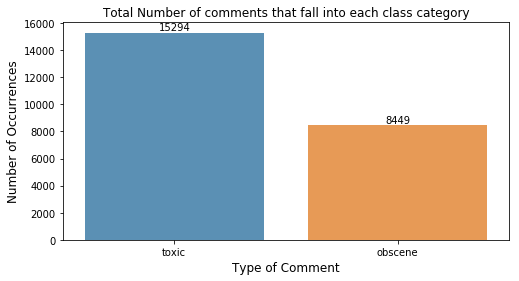

In [5]:

x=train.iloc[:,2:].sum()
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Total Number of comments that fall into each class category")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type of Comment', fontsize=12)
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [6]:
# merge the test and train 
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [7]:
#To identify indirect features :

#Sentence count 
df['sentence_count']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count 
df['word_count']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['unique_word_count']=df["comment_text"].apply(lambda x: len(set(str(x).split())))

#punctuation count
df["punctuation_count"]=df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["upper_case_count"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#Number of stopwords
df["stopwords_count"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Mean length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/Users/aarthi/libpff/anaconda3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [8]:
#Word count percent 
df['word_unique_percent']=df['unique_word_count']*100/df['word_count']
#Punctuation percent 
df['punct_percent']=df['punctuation_count']*100/df['word_count']

In [9]:
df['comment_text'].fillna("unknown", inplace=True)

In [10]:
#function to clean the comments-dataset
def clean(comment):
    #Converting to lower case 
    comment=comment.lower()
    #removing '\n'
    comment=re.sub("\\n","",comment)
    # removing ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    word_list=tokenizer.tokenize(comment)
    word_list = [w for w in word_list if not w in eng_stopwords]
    
    clean_sent=" ".join(word_list)
    #removing non alphanum,digit character
    clean_sent=re.sub("\W+"," ",clean_sent)
    clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [11]:
clean_data=df['comment_text'].apply(lambda x :clean(x))

In [12]:
df

,id,comment_text,sentence_count,word_count,unique_word_count,punctuation_count,upper_case_count,stopwords_count,mean_word_len,word_unique_percent,punct_percent
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,2,43,41,10,2,18,5.162791,95.348837,23.255814
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,1,17,17,12,1,2,5.588235,100.000000,70.588235
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",1,42,39,6,0,20,4.571429,92.857143,14.285714
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",5,113,82,21,5,56,4.486726,72.566372,18.584071
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",1,13,13,5,0,5,4.230769,100.000000,38.461538
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",3,13,12,4,0,4,3.923077,92.307692,30.769231
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,8,8,0,8,4,4.625000,100.000000,0.000000
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,1,20,20,4,0,12,4.750000,100.000000,20.000000
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,1,83,70,19,1,42,4.698795,84.337349,22.891566
9,00040093b2687caa,alignment on this subject and which are contra...,1,12,12,0,0,8,4.916667,100.000000,0.000000


In [13]:
#Unigrams - TF-IDF features
tfv = TfidfVectorizer(min_df=200,  max_features=10000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
tfv.fit(clean_data)
unigrams =  tfv.transform(clean_data)

In [14]:
#Bigrams
tfv = TfidfVectorizer(min_df=150,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(2,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_data)
bigrams =  tfv.transform(clean_data)

In [15]:
#Char-4-grams
tfv = TfidfVectorizer(min_df=100,  max_features=30000, 
            strip_accents='unicode', analyzer='char',ngram_range=(1,4),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(clean_data)
char4grams = tfv.transform(clean_data)

In [16]:
#NB Model with SVM 
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [17]:
SELECTED_COLS=['sentence_count', 'word_count', 'unique_word_count',
       'punctuation_count', 'upper_case_count', 'stopwords_count',
       'mean_word_len', 'word_unique_percent', 'punct_percent']
TEST_COLS = ['comment_text']
TARGET_COLS=['toxic', 'obscene']
train_y=train[TARGET_COLS]
dummy_test_y = pd.DataFrame(np.zeros((train_len + test.shape[0],len(TARGET_COLS))))

In [18]:
df.fillna(0,inplace=True)

In [19]:
train_x = hstack((unigrams,bigrams,char4grams,df[SELECTED_COLS])).tocsr()

In [20]:
def train_model(train_x,flag=1):
    ret = {}
    model = NbSvmClassifier(C=4, dual=True, n_jobs=-1)
        
    X_train, X_test = train_test_split(train_x, train_size=train_len)
    training_set_predictions = np.zeros((X_train.shape[0], len(TARGET_COLS)))
    testing_set_predictions = np.zeros((X_test.shape[0], len(TARGET_COLS)))

    for i, j in enumerate(TARGET_COLS):
        print('Class:= '+j)
        model.fit(X_train,train_y[j])
        training_set_predictions[:,i] = model.predict(X_train)
        testing_set_predictions[:,i] = model.predict(X_test)
    
    ret["training_set_predictions"] =training_set_predictions
    ret["testing_set_predictions"] = testing_set_predictions
    return ret

In [21]:
orig_toxic = train['toxic']
orig_obscene = train['obscene']
tfidf_ret = train_model(train_x)

/Users/aarthi/libpff/anaconda3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Class:= toxic


/Users/aarthi/libpff/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


Class:= obscene


In [26]:
def calculate_prediction_efficacy(inp):
    ret ={}
    ret["predicted_toxic"] = pd.DataFrame(inp["training_set_predictions"][:,0])
    ret["predicted_obscene"] = pd.DataFrame(inp["training_set_predictions"][:,1])
    ret["score_toxic"] = accuracy_score(inp["orig_toxic"], ret["predicted_toxic"].round()) * 100 #to get %
    ret["score_obscene"] = accuracy_score(inp["orig_obscene"], ret["predicted_obscene"].round()) * 100 #to get %
    ret["avg_accuracy"] = (ret["score_obscene"] +  ret["score_toxic"])/2
    ret["precision_toxic"], ret["recall_toxic"], ret["fscore_toxic"], ret["support_toxic"] = score(inp["orig_toxic"], ret["predicted_toxic"].round())
    print("Accuracy for toxic is " +str(ret["score_toxic"]))
    print("Accuracy for obscene is " +str(ret["score_obscene"]))
    print("Average Accuracy is " +str(ret["avg_accuracy"]))
    print("Toxic Precision score is " + str(ret["precision_toxic"][0]*100))
    print("Toxic Recall score is " + str(ret["recall_toxic"][0]*100))
    print("Toxic fscore is " + str(ret["fscore_toxic"][0]))
    ret["precision_obscene"], ret["recall_obscene"], ret["fscore_obscene"],ret["support_obscene"] = score(inp["orig_obscene"], ret["predicted_obscene"].round())
    print("obscene Precision score is " + str(ret["precision_obscene"][0]*100))
    print("obscene Recall score is " + str( ret["recall_obscene"][0]*100))
    print("obscene fscore is " + str(ret["fscore_obscene"][0]))
    ret["avg_recall"] = (ret["recall_toxic"][0]+ret["recall_obscene"][0])/2
    print ("Avg Recall = " + str(ret["avg_recall"]))
    #toxic
    ret["fpr1"], ret["tpr1"], ret["threshold1"] = metrics.roc_curve(inp["orig_toxic"], ret["predicted_toxic"].round())
    ret["roc_auc_toxic"] = metrics.auc(ret["fpr1"], ret["tpr1"])
    #obscene
    ret["fpr2"], ret["tpr2"], ret["threshold2"]  = metrics.roc_curve(inp["orig_obscene"], ret["predicted_obscene"].round())
    ret["roc_auc_obscene"] = metrics.auc(ret["fpr2"], ret["tpr2"])
    print("ruc_auc_toxic " + str(ret["roc_auc_toxic"]))
    print("ruc_auc_obscene " + str(ret["roc_auc_obscene"]))

    return ret

In [27]:
inp={}
inp["orig_toxic"] = orig_toxic
inp["orig_obscene"] = orig_obscene
inp["training_set_predictions"] = tfidf_ret["training_set_predictions"]
inp["testing_set_predictions"] = tfidf_ret["testing_set_predictions"] 
tfidf_score_ret = calculate_prediction_efficacy(inp)


Accuracy for toxic is 90.4100396367
Accuracy for obscene is 94.7029752647
Average Accuracy is 92.5565074507
Toxic Precision score is 90.4098591991
Toxic Recall score is 100.0
Toxic fscore is 0.949634221457
obscene Precision score is 94.7034363378
obscene Recall score is 99.999337744
obscene fscore is 0.972793629728
Avg Recall = 0.99999668872
ruc_auc_toxic 0.500098077678
ruc_auc_obscene 0.500233403124


In [ ]:
testid = pd.DataFrame({'id': test["id"]})
testcomment = pd.DataFrame({'comment_text': test["comment_text"]})
submission = pd.concat([testid, testcomment, pd.DataFrame(tfidf_ret["testing_set_predictions"], columns = TARGET_COLS)], axis=1)
submission.to_csv('submission11.csv', index=False)